In [1]:
# To store data
import pandas as pd

# To do linear algebra
import numpy as np

# To create models
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora

# To search directories
import os

# To use regex
import re

# To get punctuation
import string

# To parse html
from bs4 import BeautifulSoup

# To get progression bars
from tqdm import tqdm

# To measure time
from time import time

# To get simple counters
from collections import Counter

# To process natural language
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import nltk

# To use sparse matrices
from scipy.sparse import csr_matrix

# To create plots
import matplotlib.pyplot as plt

In [2]:
curr_dir = '/home/nick/Documents/NYT/'
all_headlines = []
for filename in os.listdir('/home/nick/Documents/NYT/'):
    if 'Articles' in filename:
        article_df = pd.read_csv(curr_dir + filename)
        all_headlines.extend(list(article_df.headline.values))
        break

all_headlines = [h for h in all_headlines if h != "Unknown"]
len(all_headlines)

1214

In [3]:
# Path to the data
path = '/home/nick/Documents/NYT/'

# Create file lists
files_comments = [os.path.join(path, file) for file in os.listdir(path) if file.startswith('C')]
files_articles = [os.path.join(path, file) for file in os.listdir(path) if file.startswith('A')]

# Load data
comments = []
for file in files_comments[:1]:
    comments.extend(pd.read_csv(file, low_memory=False)['commentBody'].dropna().values)
    
print('Loaded Comments: {}'.format(len(comments)))

Loaded Comments: 243832


In [4]:
nltk.download()

# Number of comments to use in the LDA
n = 5000

# To remove punctuation
re_punctuation = re.compile('['+string.punctuation+']')

# To tokenize the comments
tokenizer = RegexpTokenizer('\w+')

# Get stopwords
stop = stopwords.words('english')


# Iterate over all comments
preprocessed_comments = []
for comment in tqdm(np.random.choice(comments, n)):
    # Remove html
    comment = BeautifulSoup(comment, 'lxml').get_text().lower()
    
    # Remove punctuation
    comment = re_punctuation.sub(' ', comment)
    
    # Tokenize comments
    comment = tokenizer.tokenize(comment)
    
    # Remove stopwords
    comment = [word for word in comment if word not in stop]
    preprocessed_comments.append(comment)
    
    
# Count overall word frequency
wordFrequency = Counter()
for comment in preprocessed_comments:
    wordFrequency.update(comment)
print('Unique Words In Comments: {}'.format(len(wordFrequency)))


# Remove rare words
minimumWordOccurrences = 5
texts = [[word for word in comment if wordFrequency[word] > minimumWordOccurrences] for comment in preprocessed_comments]


# Create word dictionary
dictionary = corpora.Dictionary(texts)
vocabulary = [dictionary[i] for i in dictionary.keys()]
print('Documents/Comments: {}'.format(len(texts)))


# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in texts]


# Create sparse matrix
def makesparse(mycorpus, ncolumns):
    data, row, col = [], [], []
    for cc, doc in enumerate(mycorpus):
        for word in doc:
            row.append(cc)
            col.append(word[0])
            data.append(word[1])
    X = csr_matrix((np.array(data), (np.array(row), np.array(col))), shape=(cc+1, ncolumns))
    return X


# Create sparse matrix
X = makesparse(corpus, len(dictionary))
print('Train Shape:\t{}'.format(X.shape))

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


100%|██████████| 5000/5000 [00:01<00:00, 3846.09it/s]


Unique Words In Comments: 22077
Documents/Comments: 5000
Train Shape:	(5000, 5081)


In [5]:
# Set topic number
numberTopics = 20
print('Number of topics:\t{}'.format(numberTopics))

Number of topics:	20


### Sklearn LDA

In [ ]:
# Create the model
model_sklearn = LatentDirichletAllocation(n_components=numberTopics, 
                                          learning_method='online',
                                          n_jobs=16,
                                          max_iter = 1,
                                          total_samples = 10000,
                                          batch_size = 20)

perplexity_sklearn = []
timestamps_sklearn = []
start = time()
for _ in tqdm(range(100)):
    model_sklearn.partial_fit(X)
    # Append the models metric
    perplexity_sklearn.append(model_sklearn.perplexity(X))
    timestamps_sklearn.append(time()-start)
    
# Plot the topics
for i, topic in enumerate(model_sklearn.components_.argsort(axis=1)[:, -10:][:, ::-1], 1):
    print('Topic {}: {}'.format(i, ' '.join([vocabulary[id] for id in topic])))

  6%|▌         | 6/100 [00:34<09:07,  5.83s/it]

### Gensim LDA

In [8]:
# Create the model
model_gensim = LdaMulticore(num_topics=numberTopics,
                        id2word=dictionary,
                        iterations=10,
                        passes=1,
                        chunksize=50,
                        eta='auto',
                        workers=7)


perplexity_gensim = []
timestamps_gensim = []
start = time()
for _ in tqdm(range(100)):
    # Online update of the model
    model_gensim.update(corpus)
    # To compare sklearn and gensim the perplexity has to be transformed by np.exp(-1*x)
    perplexity_gensim.append(np.exp(-1 * model_gensim.log_perplexity(corpus)))
    timestamps_gensim.append(time() - start)
    
    
    
# Plot the topics
for i, topic in enumerate(model_gensim.get_topics().argsort(axis=1)[:, -10:][:, ::-1], 1):
    print('Topic {}: {}'.format(i, ' '.join([vocabulary[id] for id in topic])))

100%|██████████| 100/100 [02:32<00:00,  1.52s/it]

Topic 1: like would day great really going years one someone understand
Topic 2: like man see one people trump made ever president hope
Topic 3: united flight speech passenger airlines would airline passengers states free
Topic 4: like people white please see news country many black looks
Topic 5: one people person death man also like never think study
Topic 6: trump president republicans democrats party obama republican court house vote
Topic 7: mr good children us people reading little one government article
Topic 8: women would election trump men choice one clinton many win
Topic 9: war right us america world americans left like country countries
Topic 10: change read climate people could many life one article would
Topic 11: like year time much get one old would money bill
Topic 12: work school working high kids class students would college education
Topic 13: trump assad russia syria putin president would media us attack
Topic 14: tax care people health taxes insurance pay income 

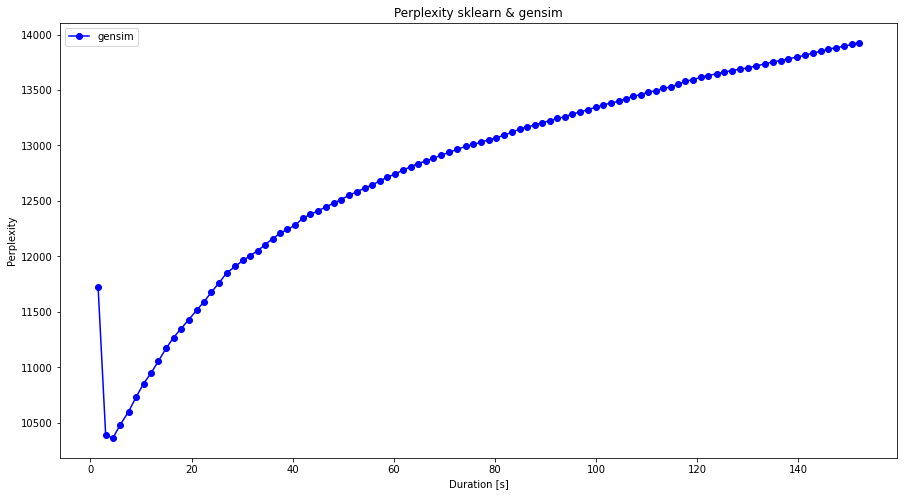

In [10]:
plt.figure(figsize=(15,8))
# plt.plot(timestamps_sklearn, perplexity_sklearn, '-o', label='sklearn', c='g')
plt.plot(timestamps_gensim, perplexity_gensim, '-o', label='gensim', c='b')
plt.title('Perplexity sklearn & gensim')
plt.xlabel('Duration [s]')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

\* Note: I got this code from https://www.kaggle.com/morrisb/compare-lda-topic-modeling-in-sklearn-and-gensim